# Unsupervised Challenge

Based on CBS data, can you discover a cluster of cities with many students? Do the city names in your cluster make sense (i.e., Amsterdam, Rotterdam, Eindhoven, Tilburg, Maastricht, Breda, Utrecht, Enschede, Groningen, Delft, and more)? Bonus question, within your cluster of 'student cities', can you discover which type of schools, universities are present (e.g., technical ones, social studies?)

The following cities are examples of student cities:
- Amsterdam
- Breda
- Delft
- Den Bosch
- Den Haag
- Eindhoven
- Enschede
- Groningen
- Leeuwarden
- Leiden 
- Maastricht
- Nijmegen
- Rotterdam
- Tilburg
- Utrecht
- Wageningen

Of course, there are more cities with a lot of students, but these are the most well-known ones.

## Read reference data: description of columns in data

The CBS dataset comes with an extra file describing the columns in the dataset. Let's read this file first.

In [135]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.environ['DATA_DIRECTORY'] = '/content'
else:
    os.environ['DATA_DIRECTORY'] = '../../data'

data_directory = os.getenv('DATA_DIRECTORY')

In [136]:
%%bash
if [ ! -f "$DATA_DIRECTORY/course-data.zip" ]; then
    wget "https://gitlab.com/api/v4/projects/52375047/jobs/artifacts/master/raw/data/course-data.zip?job=build_data_zip" -O "$DATA_DIRECTORY/course-data.zip"
    unzip "$DATA_DIRECTORY/course-data.zip" -d "$DATA_DIRECTORY"
fi

In [137]:
import pandas as pd
 
kwb_description = pd.read_csv(os.path.join(data_directory, "kwb-2018-toelichting.csv"), delimiter=';', names=["column_name", "description", "comments"], index_col=0)
kwb_description.drop(columns=["comments"], inplace=True)
kwb_description.head()

description
column_name                 
gwb_code_10      gwb code 10
gwb_code_8        gwb code 8
regio        Regioaanduiding
gm_naam         Gemeentenaam
recs             Soort regio

We can see that for every column in the dataset, there is a description of the column. This will help us understand the dataset better. So if for example we want to know what the column `a_pau` means, we can look it up in this file using the following code:

In [138]:
kwb_description.loc['a_pau']  # use these descriptions to try and determine the parameter being asked.

description    Personenauto's totaal
Name: a_pau, dtype: object

After reading the metadata, we can read the dataset itself. The dataset is stored in a CSV file, so we can use the `read_csv` function from the `pandas` library to read the dataset. We will also print the first few rows of the dataset to get an idea of what the dataset looks like.

In [139]:
kwb_data = pd.read_csv(os.path.join(data_directory, "kwb-2018.csv"), delimiter=';', encoding="latin1")
kwb_data.head()

gwb_code_10  gwb_code_8               regio     gm_naam      recs  \
0        NL00           0           Nederland   Nederland      Land   
1      GM0003           3          Appingedam  Appingedam  Gemeente   
2    WK000300         300             Wijk 00  Appingedam      Wijk   
3  BU00030000       30000  Appingedam-Centrum  Appingedam     Buurt   
4  BU00030001       30001     Appingedam-West  Appingedam     Buurt   

     gwb_code ind_wbi     a_inw    a_man  a_vrouw  ...  a_bst_b  a_bst_nb  \
0        NL00       .  17181084  8527041  8654043  ...  6649495   1723750   
1      GM0003       .     11801     5751     6050  ...     4650       790   
2    WK000300       1     11800     5750     6050  ...     4645       790   
3  BU00030000       1      2355     1120     1235  ...      925       150   
4  BU00030001       1      3030     1505     1525  ...     1305       240   

   g_pau_hh  g_pau_km   a_m2w  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  ste_oad  
0       1,1       249  661640   4154338   3367109    787228        2     1978  
1         1       229     550      2458      2378        80        3     1051  
2         1       229     550      2458      2378        80        3     1051  
3       0,8      1275      95        90        84         5        3     1195  
4       1,2       977     155       163       158         5        4      896  

[5 rows x 56 columns]

## Selecting the data we want to use

The dataset contains several types of regions, but we are only interested in the municipalities. We first have to find the rows that correspond to municipalities. Let's look at the metadata to find the column containing the region type.

In [140]:
kwb_description

description
column_name                            
gwb_code_10                 gwb code 10
gwb_code_8                   gwb code 8
regio                   Regioaanduiding
gm_naam                    Gemeentenaam
recs                        Soort regio
...                                 ...
a_wat_ha              Oppervlakte water
pst_mvp      Meest voorkomende postcode
pst_dekp             Dekkingspercentage
ste_mvs          Mate van stedelijkheid
ste_oad      Omgevingsadressendichtheid

[109 rows x 1 columns]

We can see here that the `recs` column contains the region type:

In [141]:
kwb_description.loc['recs']

description    Soort regio
Name: recs, dtype: object

To see what values the `recs` column can have, we can use the `unique` function from the `pandas` library. This function returns all unique values in a column.

In [142]:
kwb_data['recs'].unique()

array(['Land', 'Gemeente', 'Wijk', 'Buurt'], dtype=object)

In [143]:
selected_region_type = 'Gemeente'

We can filter the dataset to only include the municipalities by selecting the rows where the `recs` column is equal to `Gemeente`. 

In [144]:
data_for_selected_region_type = kwb_data[kwb_data.recs == selected_region_type].copy()
data_for_selected_region_type.head()

gwb_code_10  gwb_code_8       regio     gm_naam      recs gwb_code ind_wbi  \
1       GM0003           3  Appingedam  Appingedam  Gemeente   GM0003       .   
9       GM0005           5       Bedum       Bedum  Gemeente   GM0005       .   
19      GM0009           9    Ten Boer    Ten Boer  Gemeente   GM0009       .   
34      GM0010          10    Delfzijl    Delfzijl  Gemeente   GM0010       .   
64      GM0014          14   Groningen   Groningen  Gemeente   GM0014       .   

     a_inw   a_man  a_vrouw  ...  a_bst_b  a_bst_nb  g_pau_hh  g_pau_km  \
1    11801    5751     6050  ...     4650       790         1       229   
9    10475    5235     5240  ...     4045       965       1,1       112   
19    7292    3616     3676  ...     3025       710       1,3        82   
34   24864   12475    12389  ...    10220      2280       1,1        94   
64  202810  101299   101511  ...    53560     19295       0,6       768   

    a_m2w  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  ste_oad  
1     550      2458      2378        80        3     1051  
9     515      4496      4454        41        4      685  
19    445      4573      4531        42        5      372  
34   1285     22750     13307      9443        4      677  
64   5255     10150      9492       658        1     3456  

[5 rows x 56 columns]

Next, we can check how many municipalities are in the dataset.

In [145]:
len(data_for_selected_region_type)

380

The filtered dataset contains 380 municipalities. The data is from 2018, and indeed that number is correct. 

## Creating derived variables: An example

The dataset contains several columns that we can use to create derived variables. For example, we can use the percentage of rental houses to derive a new variable that instead gives the fraction of houses rented (between 0 and 1). We do this by dividing the percentage of rental houses by 100:


In [146]:
# data cleaning
data_for_selected_region_type['p_huurw_f'] = pd.to_numeric(data_for_selected_region_type['p_huurw'], downcast="float", errors="coerce") / 100
data_for_selected_region_type['p_huurw_f'].head()

1     0.51
9     0.31
19    0.23
34    0.38
64    0.61
Name: p_huurw_f, dtype: float32

To solve the challenge, you will need to create new derived variables that help you answer the question.

## Design features that allows you to answer the question, find the right clusters using some clustering algorithm

Based on CBS data, can you discover a cluster of cities with many students? Do the city names in your cluster make sense? Bonus question, within your cluster of 'student cities', can you discover which type of schools, universities are present (e.g., technical ones, social studies?)

In [147]:
#begin solution

In [148]:
# feature engineering
data_for_selected_region_type['perc_ongehuwd'] = data_for_selected_region_type['a_ongeh'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_vrouwen'] = data_for_selected_region_type['a_vrouw'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_15_24'] = data_for_selected_region_type['a_15_24'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_hh_z_k'] = data_for_selected_region_type['a_hh_z_k'] / (data_for_selected_region_type['a_hh'])
data_for_selected_region_type.head()

gwb_code_10  gwb_code_8       regio     gm_naam      recs gwb_code ind_wbi  \
1       GM0003           3  Appingedam  Appingedam  Gemeente   GM0003       .   
9       GM0005           5       Bedum       Bedum  Gemeente   GM0005       .   
19      GM0009           9    Ten Boer    Ten Boer  Gemeente   GM0009       .   
34      GM0010          10    Delfzijl    Delfzijl  Gemeente   GM0010       .   
64      GM0014          14   Groningen   Groningen  Gemeente   GM0014       .   

     a_inw   a_man  a_vrouw  ...  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  \
1    11801    5751     6050  ...      2458      2378        80        3   
9    10475    5235     5240  ...      4496      4454        41        4   
19    7292    3616     3676  ...      4573      4531        42        5   
34   24864   12475    12389  ...     22750     13307      9443        4   
64  202810  101299   101511  ...     10150      9492       658        1   

    ste_oad  p_huurw_f  perc_ongehuwd  perc_vrouwen  perc_15_24  perc_hh_z_k  
1      1051       0.51       0.424795      0.512668    0.101856     0.320397  
9       685       0.31       0.437709      0.500239    0.113126     0.347529  
19      372       0.23       0.443637      0.504114    0.116292     0.329866  
34      677       0.38       0.414776      0.498271    0.105253     0.326504  
64     3456       0.61       0.678399      0.500523    0.235062     0.207996  

[5 rows x 61 columns]

After deriving the variables, select only those variables from the dataset:

In [149]:
unsupervised_data = data_for_selected_region_type[['perc_15_24','perc_ongehuwd','perc_hh_z_k','p_huurw_f','perc_vrouwen']]
unsupervised_data.shape

(380, 5)

# Clustering the Data

Now that we have selected the data we want to use, we can start clustering the data. We will use the KMeans algorithm to cluster the data. We use the Elbow method to determine the optimal number of clusters.

In [150]:
from sklearn.cluster import KMeans

def evaluate_kmeans(data: pd.DataFrame, 
                    min_clusters: int = 1,
                    max_clusters: int = 10, 
                    evaluation_function = lambda data, kmeans: kmeans.inertia_):
    scores = []

    for k in range(min_clusters, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        score = evaluation_function(data, kmeans)
        scores.append(score)
    return scores 

<Axes: >

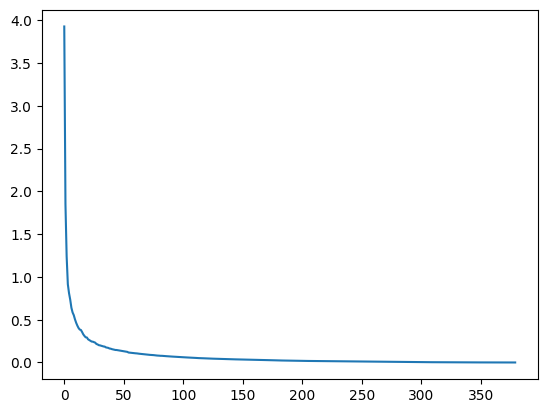

In [151]:
import seaborn as sns

inertia = evaluate_kmeans(unsupervised_data, max_clusters=len(unsupervised_data))

sns.lineplot(inertia)

In [152]:
best_k = 5

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(unsupervised_data)

# predictions for all gemeentes
df_predictions = pd.DataFrame({"cluster" : kmeans.labels_})

# we now want to make a dataset with cluster (the predictions), we first copy the unsupervised dataset
unsupervised_data_w_cluster = unsupervised_data

# assign cluster to dataset
unsupervised_data_w_cluster = unsupervised_data_w_cluster.assign(cluster = df_predictions.values)

# assign the name of gemeente to dataset
unsupervised_data_w_cluster = unsupervised_data_w_cluster.assign(gm_naam = data_for_selected_region_type['gm_naam'].values)

unsupervised_data_w_cluster.head()

perc_15_24  perc_ongehuwd  perc_hh_z_k  p_huurw_f  perc_vrouwen  cluster  \
1     0.101856       0.424795     0.320397       0.51      0.512668        1   
9     0.113126       0.437709     0.347529       0.31      0.500239        4   
19    0.116292       0.443637     0.329866       0.23      0.504114        0   
34    0.105253       0.414776     0.326504       0.38      0.498271        2   
64    0.235062       0.678399     0.207996       0.61      0.500523        3   

       gm_naam  
1   Appingedam  
9        Bedum  
19    Ten Boer  
34    Delfzijl  
64   Groningen

In [153]:
kwb_description

description
column_name                            
gwb_code_10                 gwb code 10
gwb_code_8                   gwb code 8
regio                   Regioaanduiding
gm_naam                    Gemeentenaam
recs                        Soort regio
...                                 ...
a_wat_ha              Oppervlakte water
pst_mvp      Meest voorkomende postcode
pst_dekp             Dekkingspercentage
ste_mvs          Mate van stedelijkheid
ste_oad      Omgevingsadressendichtheid

[109 rows x 1 columns]

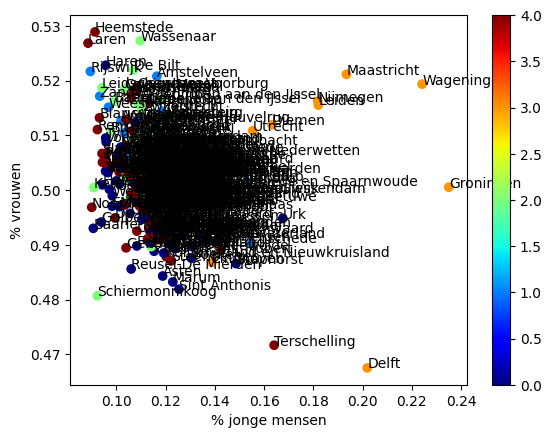

In [154]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

feature_one = 'perc_15_24'
feature_two = 'perc_vrouwen'

plt.scatter(unsupervised_data_w_cluster[feature_one], unsupervised_data_w_cluster[feature_two], c=unsupervised_data_w_cluster['cluster'], cmap=cm.jet)
plt.colorbar()
plt.xlabel('% jonge mensen')
plt.ylabel('% vrouwen')

# comment out for not showing labels
for i, txt in enumerate(unsupervised_data_w_cluster['gm_naam']):
    x_co = unsupervised_data_w_cluster.iloc[i][feature_one]
    y_co = unsupervised_data_w_cluster.iloc[i][feature_two]
    plt.annotate(txt, (x_co, y_co))

One cluster in the figure above contains a lot of the student cities: Maastricht, Wageningen, Nijmegen, Utrecht, Groningen, Delft. Let's check which cities are in this cluster.

In [155]:
cluster_nr = unsupervised_data_w_cluster[unsupervised_data_w_cluster['gm_naam']=="Maastricht"]['cluster'].values[0]
unsupervised_data_w_cluster[unsupervised_data_w_cluster['cluster']==cluster_nr][['gm_naam','cluster']]

gm_naam  cluster
64         Groningen        3
2648          Arnhem        3
3561        Nijmegen        3
3835      Wageningen        3
4683         Utrecht        3
5156       Amsterdam        3
5907          Diemen        3
7447           Delft        3
7805   's-Gravenhage        3
8143          Leiden        3
8510       Rotterdam        3
10131      Eindhoven        3
11921     Maastricht        3

All of these cities are student cities. We can see that the clustering algorithm has successfully identified a cluster of cities with many students. 


## Dimensionality Reduction: PCA

[[ 0.07316871  0.32016737 -0.31361648  0.89050677  0.02795703]
 [ 0.26256787  0.74348393 -0.42865954 -0.43829592 -0.04937051]
 [ 0.51159693  0.30038939  0.74359437  0.12075019 -0.28376328]
 [ 0.78053196 -0.49907184 -0.36635211 -0.01102668 -0.08580031]
 [ 0.233972    0.07360716  0.17535462 -0.01386299  0.95336125]]


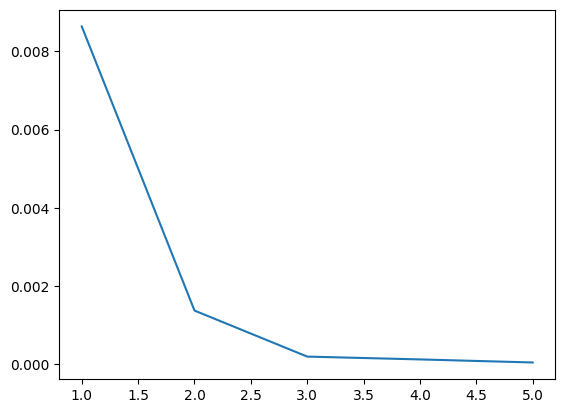

In [156]:
from sklearn.decomposition import PCA
from sklearn import decomposition

pca = PCA()
pca.fit(unsupervised_data)

# the covariance matrix
print(pca.components_)

plt.plot(list(range(1, len(pca.explained_variance_)+1)) , pca.explained_variance_)

In [157]:
pca.n_components = 2
dataset_reduced = pca.fit_transform(unsupervised_data)
dataset_reduced

array([[ 1.41355216e-01, -8.98809540e-02],
       [-4.06432371e-02, -6.77550696e-04],
       [-1.04106374e-01,  4.70048289e-02],
       [ 2.03125795e-02, -4.13659706e-02],
       [ 3.56259570e-01,  1.38597291e-01],
       [-8.29481051e-02,  6.80713136e-02],
       [-5.55127307e-02,  2.56532163e-02],
       [-1.13951921e-04, -1.31572659e-02],
       [-1.79785978e-02, -2.06252129e-02],
       [-6.57216177e-02,  4.05347798e-02],
       [ 6.36416513e-02,  8.66119388e-02],
       [ 2.37172266e-02, -5.61419139e-02],
       [-1.24610107e-02, -1.71684408e-02],
       [ 6.13980825e-04,  5.48213973e-02],
       [-3.43897797e-02,  7.13198375e-03],
       [-8.23842409e-02,  4.51710374e-02],
       [ 1.18261519e-02,  1.02490106e-02],
       [ 9.93394596e-03,  8.46538679e-03],
       [-5.11308343e-02,  1.85614541e-02],
       [ 8.88578072e-02, -3.75503229e-02],
       [ 5.81381559e-02, -8.63586974e-03],
       [-3.24945559e-02,  3.58391453e-02],
       [ 1.70008246e-01,  4.18761234e-02],
       [-1.

In [158]:
k = 5
kmeans = KMeans(n_clusters=k).fit(dataset_reduced)

In [159]:
# predictions for all gemeentes
df_predictions_reduced = pd.DataFrame({"cluster" : kmeans.predict(dataset_reduced).tolist()})

# we now want to make a dataset with cluster (the predictions), we first copy the unsupervised dataset
data_reduced_w_cluster =  pd.DataFrame(dataset_reduced)

# assign cluster to dataset
data_reduced_w_cluster = data_reduced_w_cluster.assign(cluster = df_predictions_reduced.values)

# assign the name of gemeente to dataset
data_reduced_w_cluster = data_reduced_w_cluster.assign(gm_naam = data_for_selected_region_type['gm_naam'].values)
data_reduced_w_cluster.head()

0         1  cluster     gm_naam
0  0.141355 -0.089881        1  Appingedam
1 -0.040643 -0.000678        0       Bedum
2 -0.104106  0.047005        4    Ten Boer
3  0.020313 -0.041366        3    Delfzijl
4  0.356260  0.138597        2   Groningen

In [160]:
cluster_nr = data_reduced_w_cluster[data_reduced_w_cluster['gm_naam']=="Maastricht"]['cluster'].values[0]
data_reduced_w_cluster[data_reduced_w_cluster['cluster']==cluster_nr][['gm_naam','cluster']]

gm_naam  cluster
4        Groningen        2
28        Vlieland        2
57          Arnhem        2
79        Nijmegen        2
88      Wageningen        2
111        Utrecht        2
121      Amsterdam        2
128         Diemen        2
164          Delft        2
168  's-Gravenhage        2
177         Leiden        2
191      Rotterdam        2
237      Eindhoven        2
282     Maastricht        2

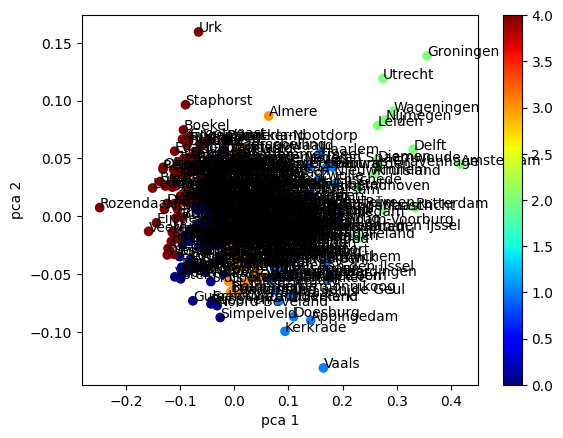

In [161]:
feature_one = 0
feature_two = 1

plt.scatter(data_reduced_w_cluster[feature_one], data_reduced_w_cluster[feature_two], c=data_reduced_w_cluster['cluster'], cmap=cm.jet)
plt.colorbar()
plt.xlabel('pca 1')
plt.ylabel('pca 2')

# comment out for not showing labels
for i, txt in enumerate(data_reduced_w_cluster['gm_naam']):
    x_co = data_reduced_w_cluster.iloc[i][feature_one]
    y_co = data_reduced_w_cluster.iloc[i][feature_two]
    plt.annotate(txt, (x_co, y_co))

In [162]:
#end solution